# RNA family characterization

Application scenario: we want to characterize RNA family, identifying regions with their structural contexts that are characteristic of the family

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import logging
from eden.util import configure_logging
configure_logging(logging.getLogger(), verbosity=2)

given the RFAM id of a family we retrieve it from the RFAM online database
composing the correspondent URL

In [2]:
rfam_id = 'RF00871' #microRNA mir-689

In [3]:
rfam_id = 'RF00380' #

In [4]:
rfam_id = 'RF02275' #Hammerhead_HH9

In [5]:
rfam_id = 'RF00005' #tRNA

In [6]:
from eden_rna.io.rfam import load
seqs = list(load(rfam_id, range(6)))

In [156]:
from GArDen.interfaces import convert, transform, compose, decompose, partition
from itertools import islice
def chain(iterable):
    for it in iterable:
        for element in it:
            yield element

def annotate(graphs):
    from GArDen.decompose import SplitConnectedComponents
    parameters_priors = dict(attribute='ref')
    graphs_lists = decompose(graphs, program=SplitConnectedComponents(), parameters_priors=parameters_priors)
    graphs = chain(graphs_lists)

    from GArDen.transform.rna_annotation import AnnotateSecondaryStructureElements
    graphs=transform(graphs, program=AnnotateSecondaryStructureElements())
    from GArDen.transform.contraction import Minor, contraction_modifier
    #reduce all 'part_name' attributes of contracted nodes to a histogram to be written in the 'label' attribute of the resulting graph 
    label_modifier = contraction_modifier(attribute_in='part_name', attribute_out='label', reduction='set_categorical')
    #reduce all 'weight' attributes of contracted nodes using a sum to be written in the 'weight' attribute of the resulting graph 
    weight_modifier = contraction_modifier(attribute_in='weight', attribute_out='weight', reduction='sum')
    modifiers = [label_modifier, weight_modifier]
    priors=dict(nesting=True, modifiers=[modifiers], weight_scaling_factor=1)
    graphs=transform(graphs, program=Minor(), parameters_priors=priors)

    from GArDen.partition import ExplicitClusterer
    parameters_priors = dict(attribute='ref')
    graphs_lists = partition(graphs, program=ExplicitClusterer(), parameters_priors=parameters_priors)

    from GArDen.compose import DisjointUnion
    graphs = compose(graphs_lists, program=DisjointUnion())
    
    return graphs

def pre_process(data):
    from GArDen.convert.sequence import FastaToPathGraph
    graphs=transform(data, program=FastaToPathGraph())
    from GArDen.transform.rna_structure import PathGraphToRNAShapes
    parameters_priors = dict(shape_type=5, energy_range=35, max_num=3, output_type='disjoint_union')
    graphs = transform(graphs, program=PathGraphToRNAShapes(), parameters_priors=parameters_priors)

    #since later partitioning needs to process all the input we limit to 10
    graphs=islice(graphs,3)
    graphs = annotate(graphs)
    #from GArDen.transform import DeleteEdge
    #graphs = transform(graphs,program=DeleteEdge(), parameters_priors=dict(attribute='type',value='basepair'))
    #from GArDen.decompose import SplitConnectedComponents
    #parameters_priors = dict(attribute='ref')
    #graphs_lists = decompose(graphs, program=SplitConnectedComponents(), parameters_priors=parameters_priors)
    #from GArDen.compose import Union
    #graphs = compose(graphs_lists, program=Union())

    return graphs

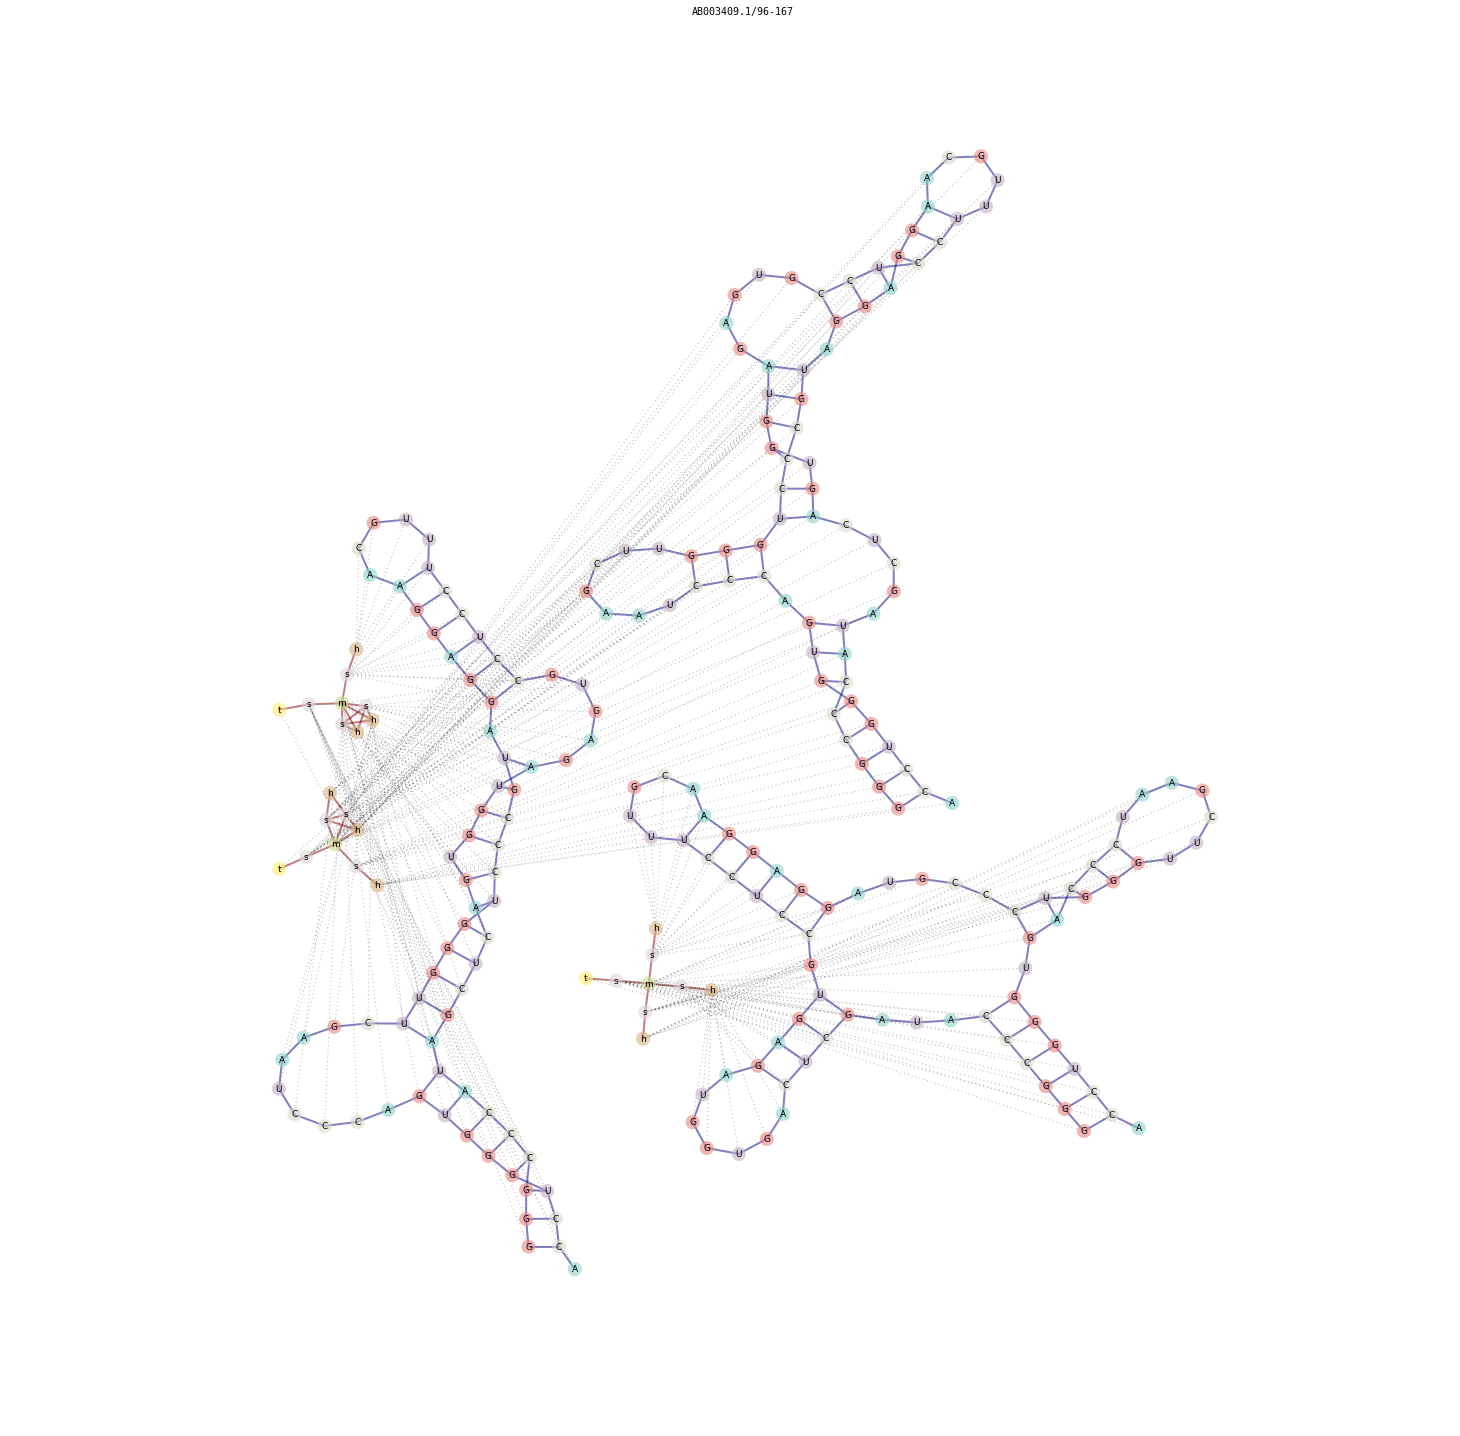

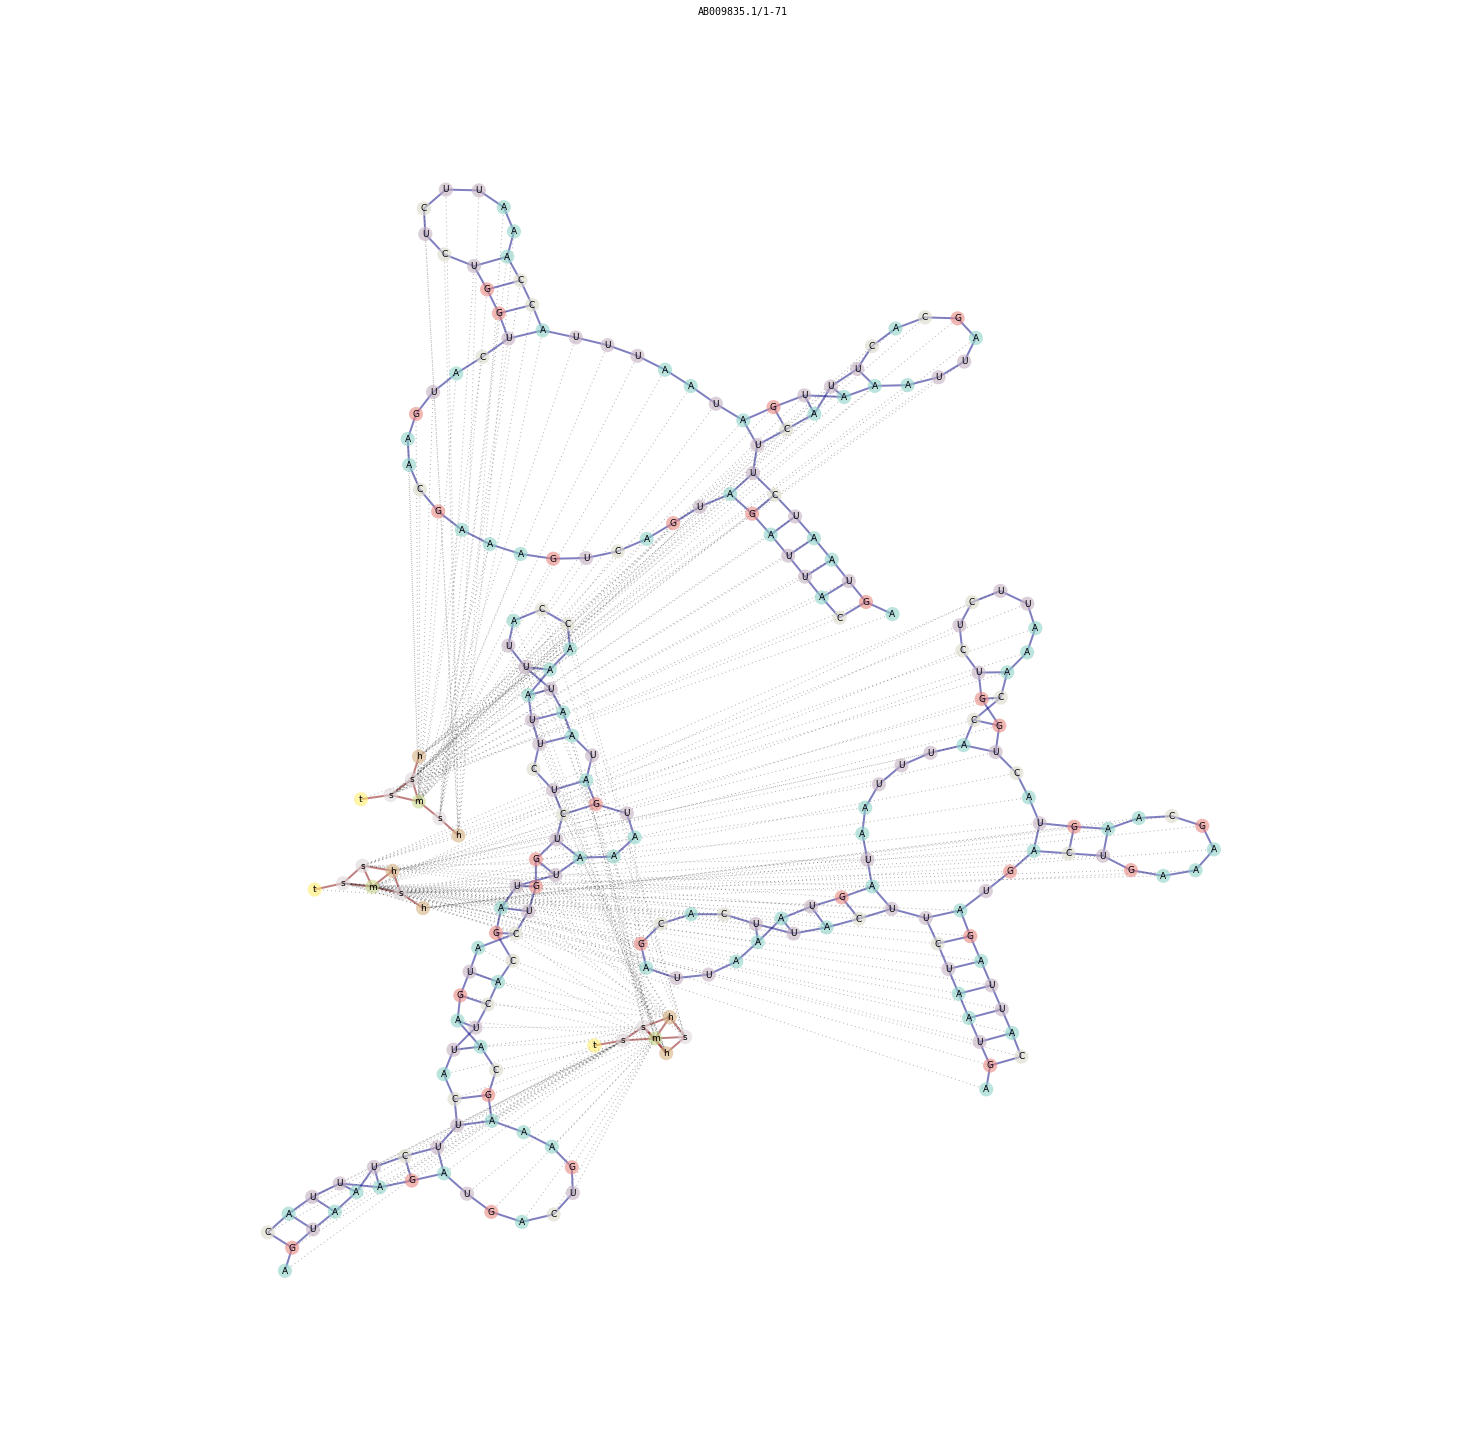

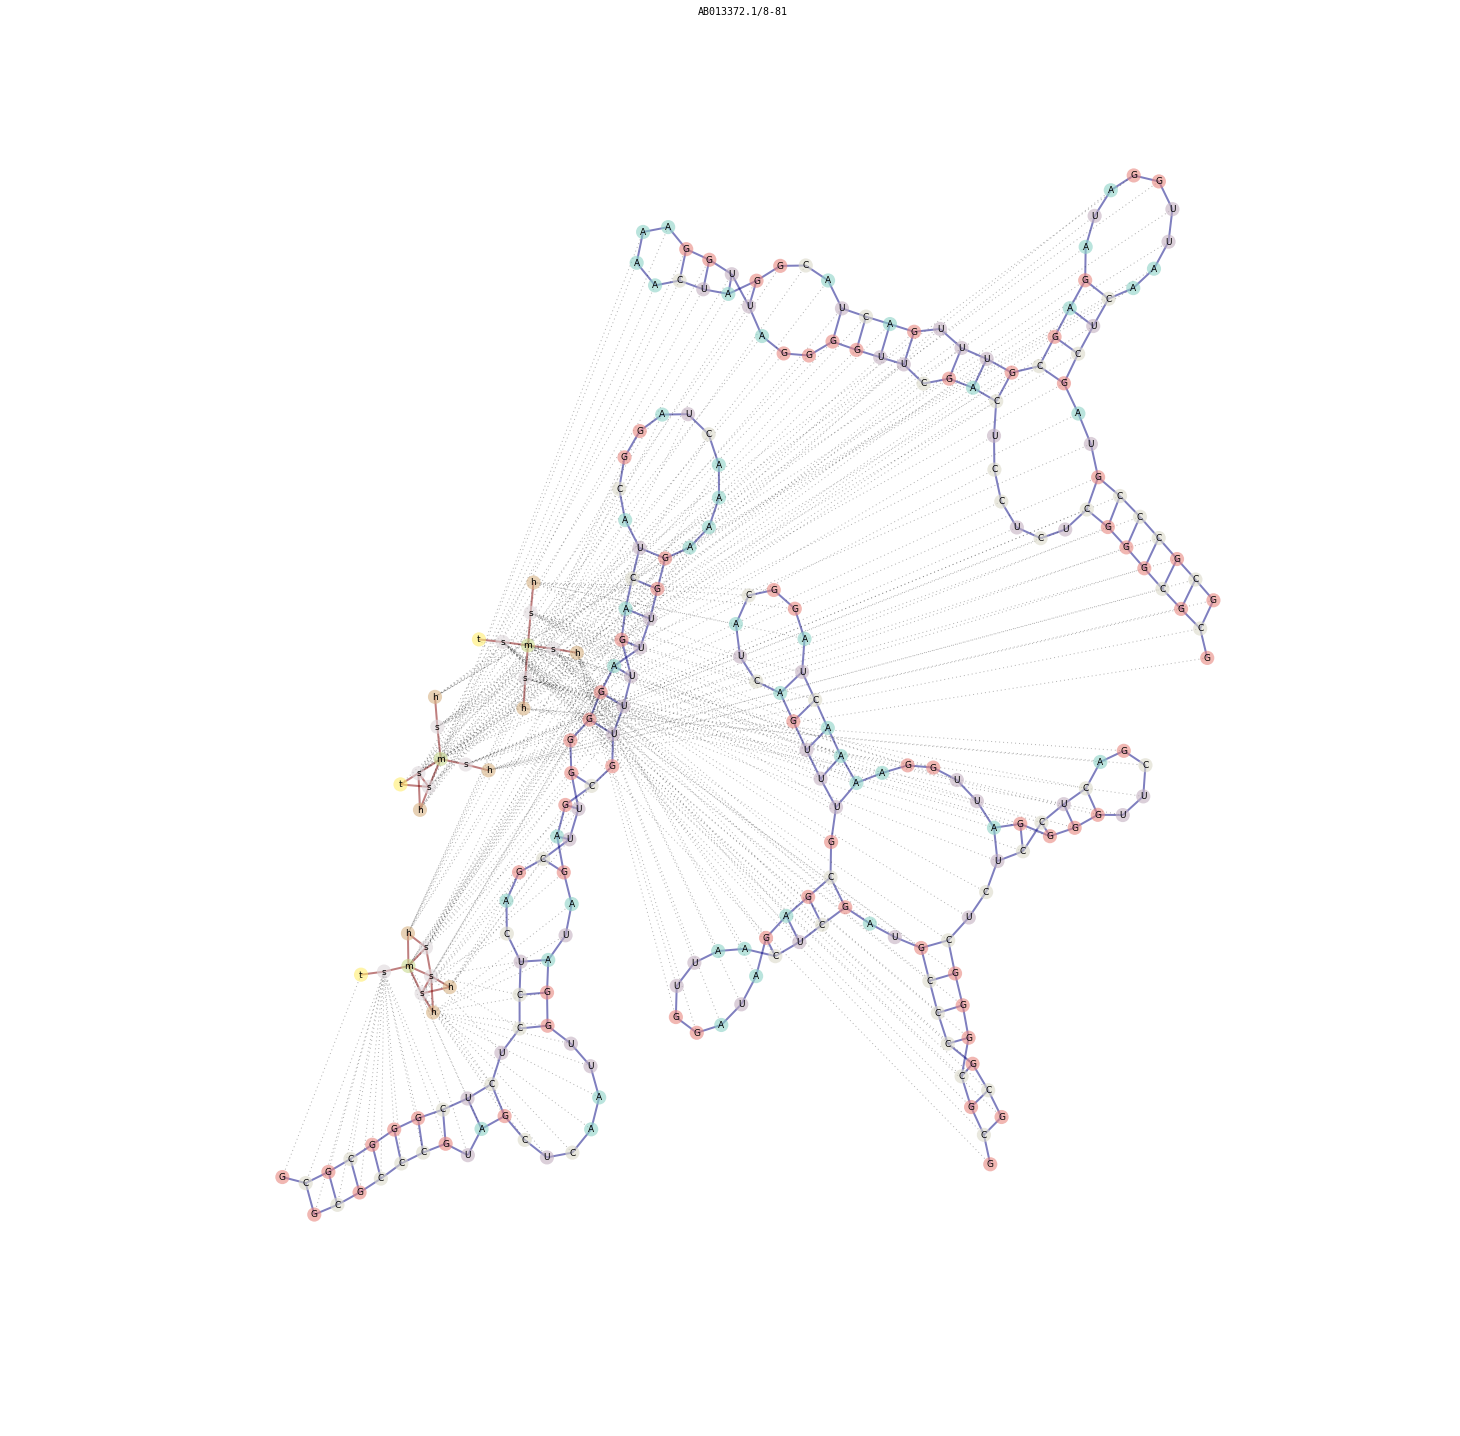

In [157]:
graphs = pre_process(rfam_uri(rfam_id))
my_opt=dict(opts)
my_opt.update({'size':25,'vertex_color':'_label_', 'colormap':'Set3', 'edge_color':'_labels_', 'edge_label':None, 'ignore_for_layout':'nesting'})
plot(graphs, opts=my_opt)

In [120]:
def pre_process(data):
    from GArDen.interfaces import convert, transform, compose, decompose, partition
    from GArDen.convert.sequence import FastaToPathGraph
    graphs=transform(data, program=FastaToPathGraph())
    from GArDen.transform.rna_structure import PathGraphToRNASubopt
    parameters_priors = dict(energy_range=10, max_num=4, split_components=False)
    graphs = transform(graphs, program=PathGraphToRNASubopt(), parameters_priors=parameters_priors)
    #since later partitioning needs to process all the input we limit to 10
    graphs=islice(graphs,3)
    graphs = annotate(graphs)
    return graphs

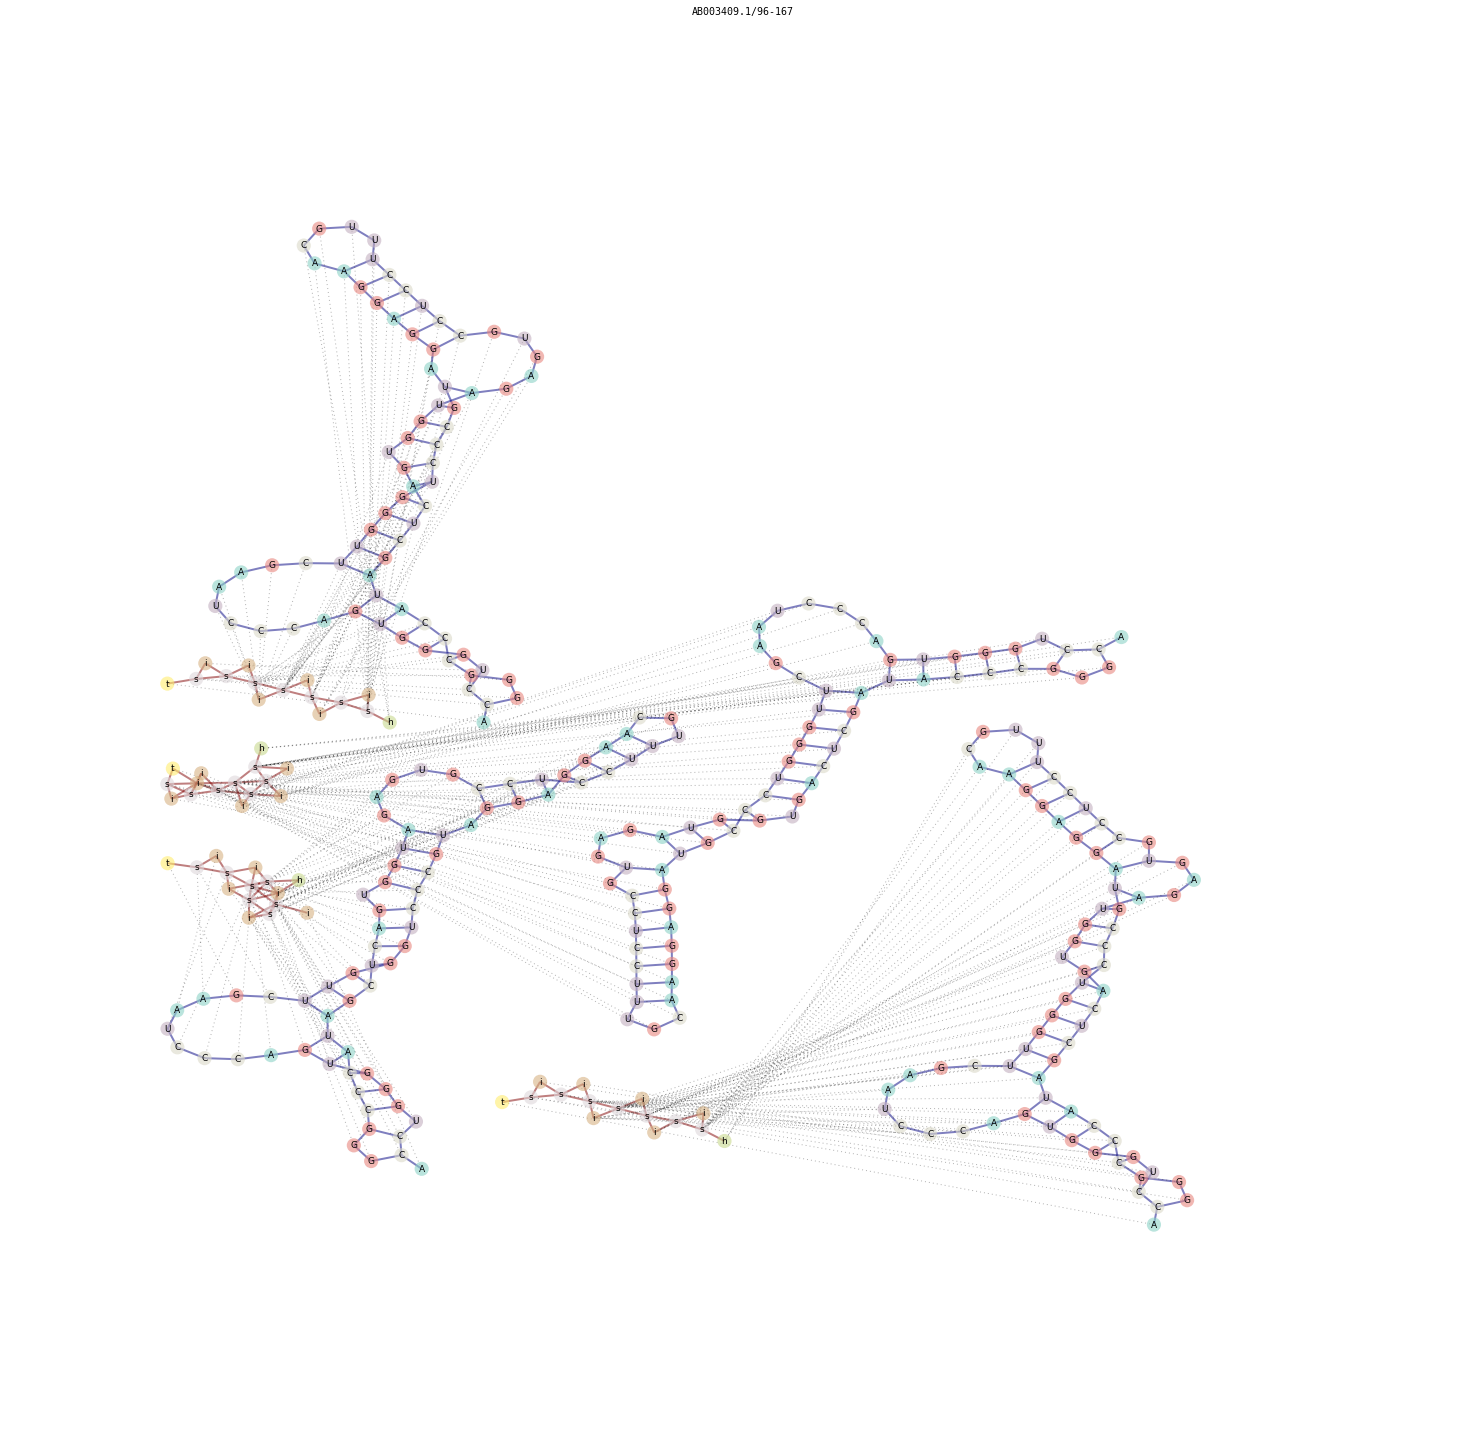

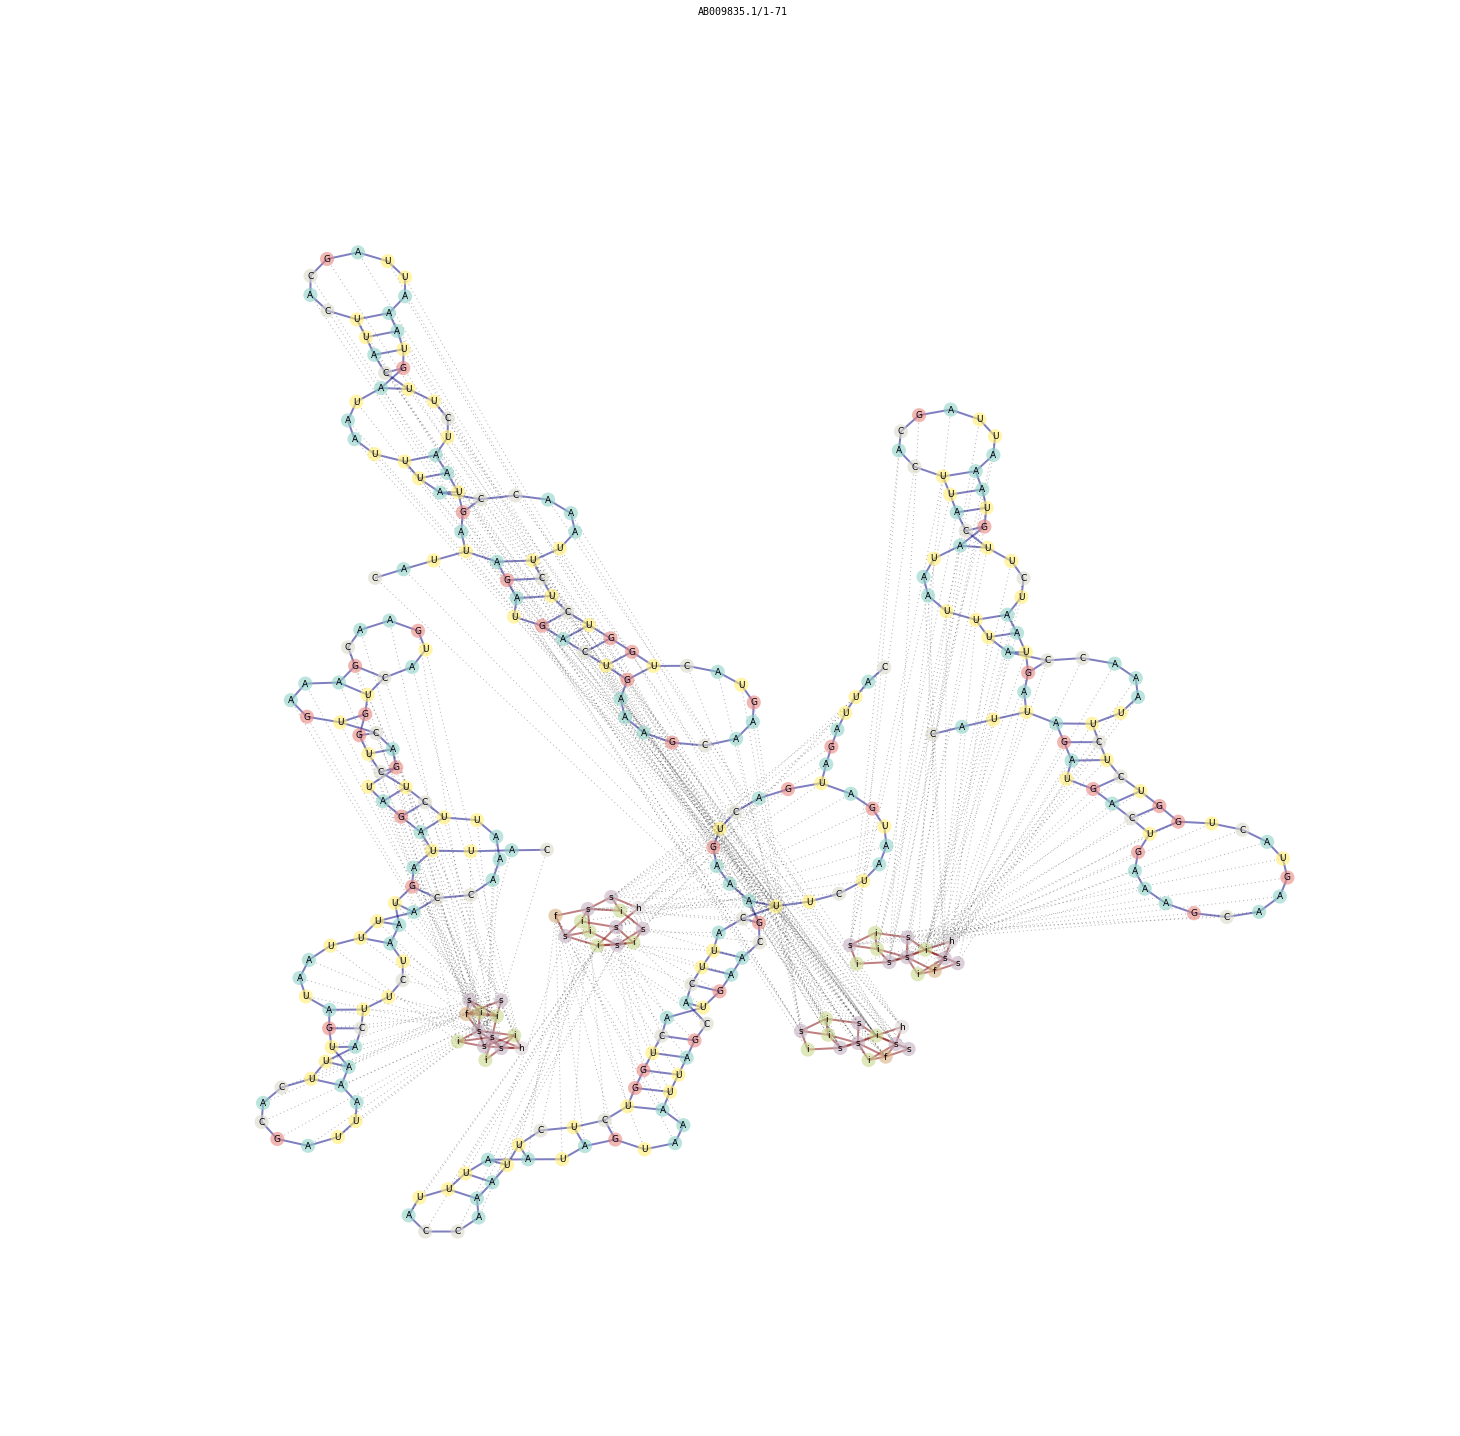

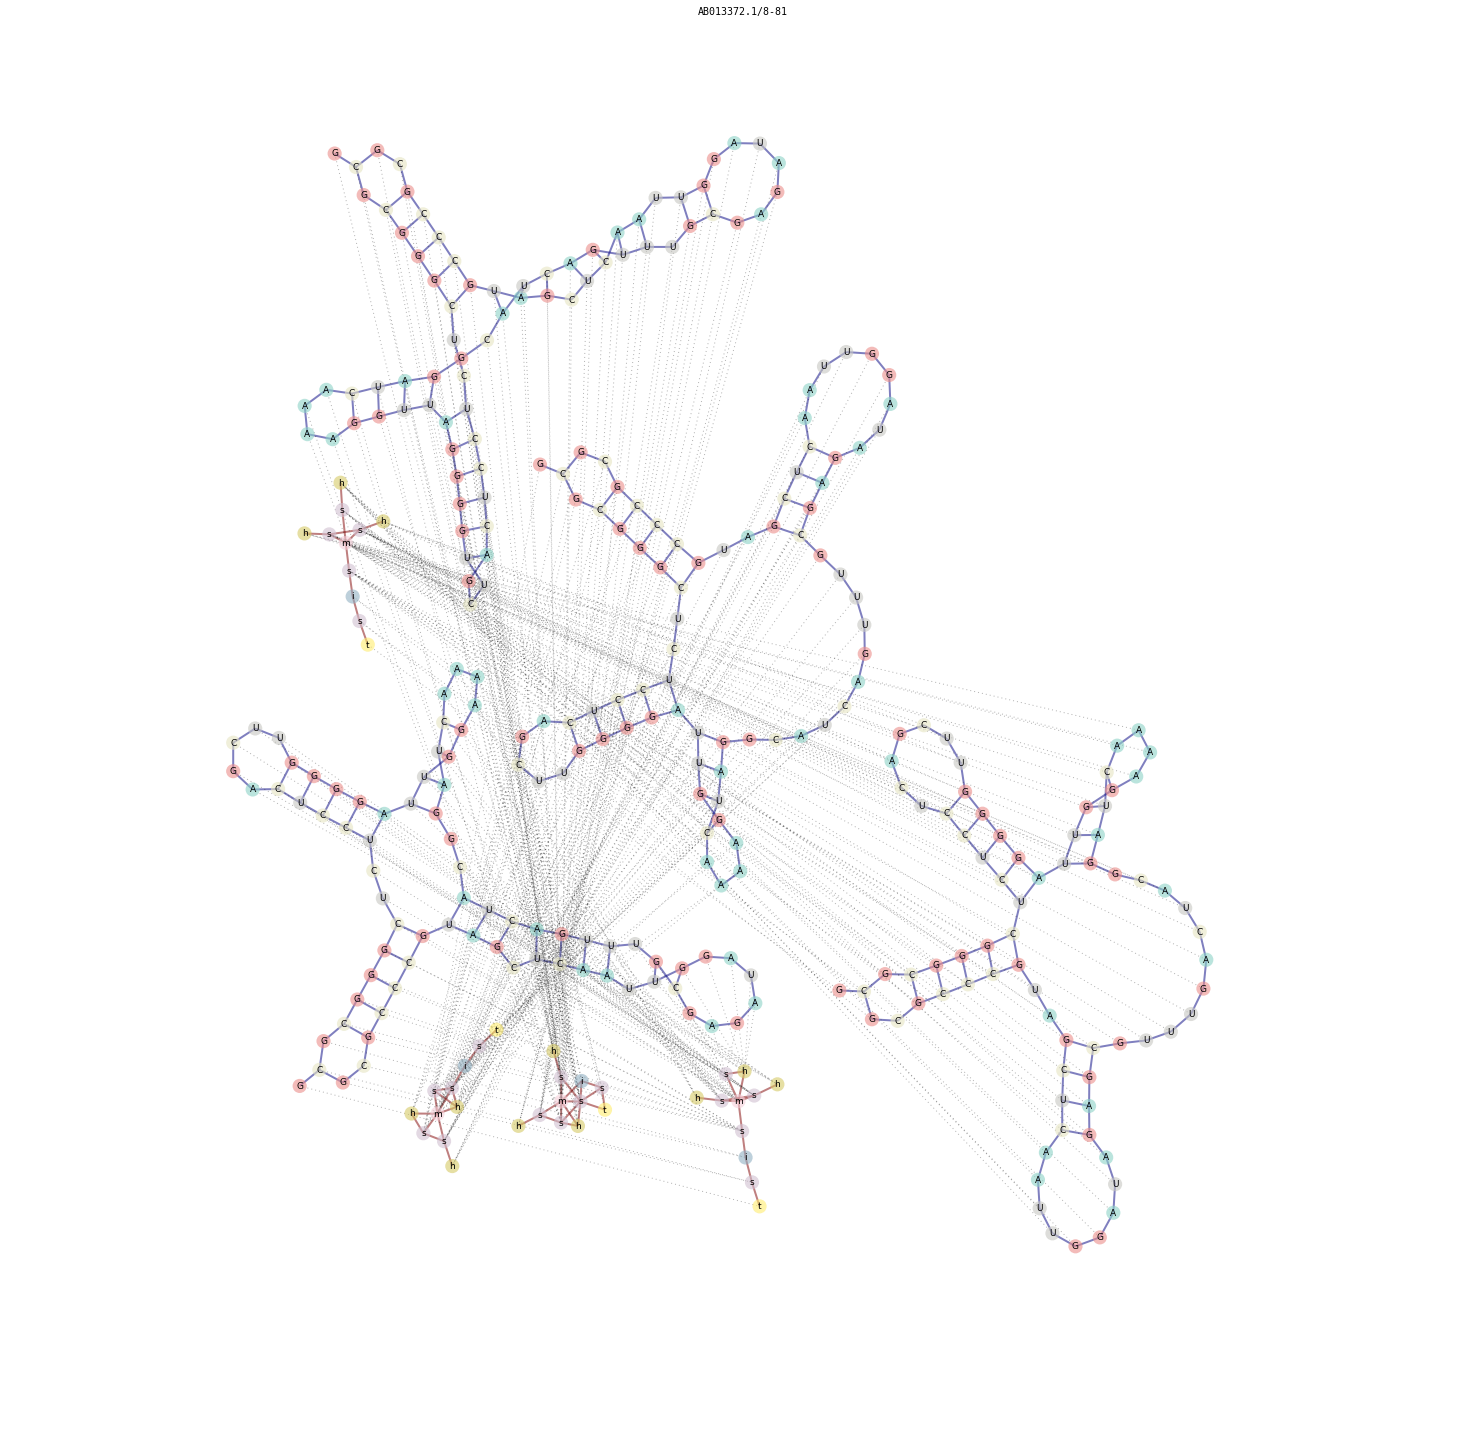

In [121]:
graphs = pre_process(rfam_uri(rfam_id))
my_opt=dict(opts)
my_opt.update({'size':25,'vertex_color':'_label_', 'colormap':'Set3', 'edge_color':'_labels_', 'edge_label':None, 'ignore_for_layout':'nesting'})
plot(graphs,opts=my_opt)

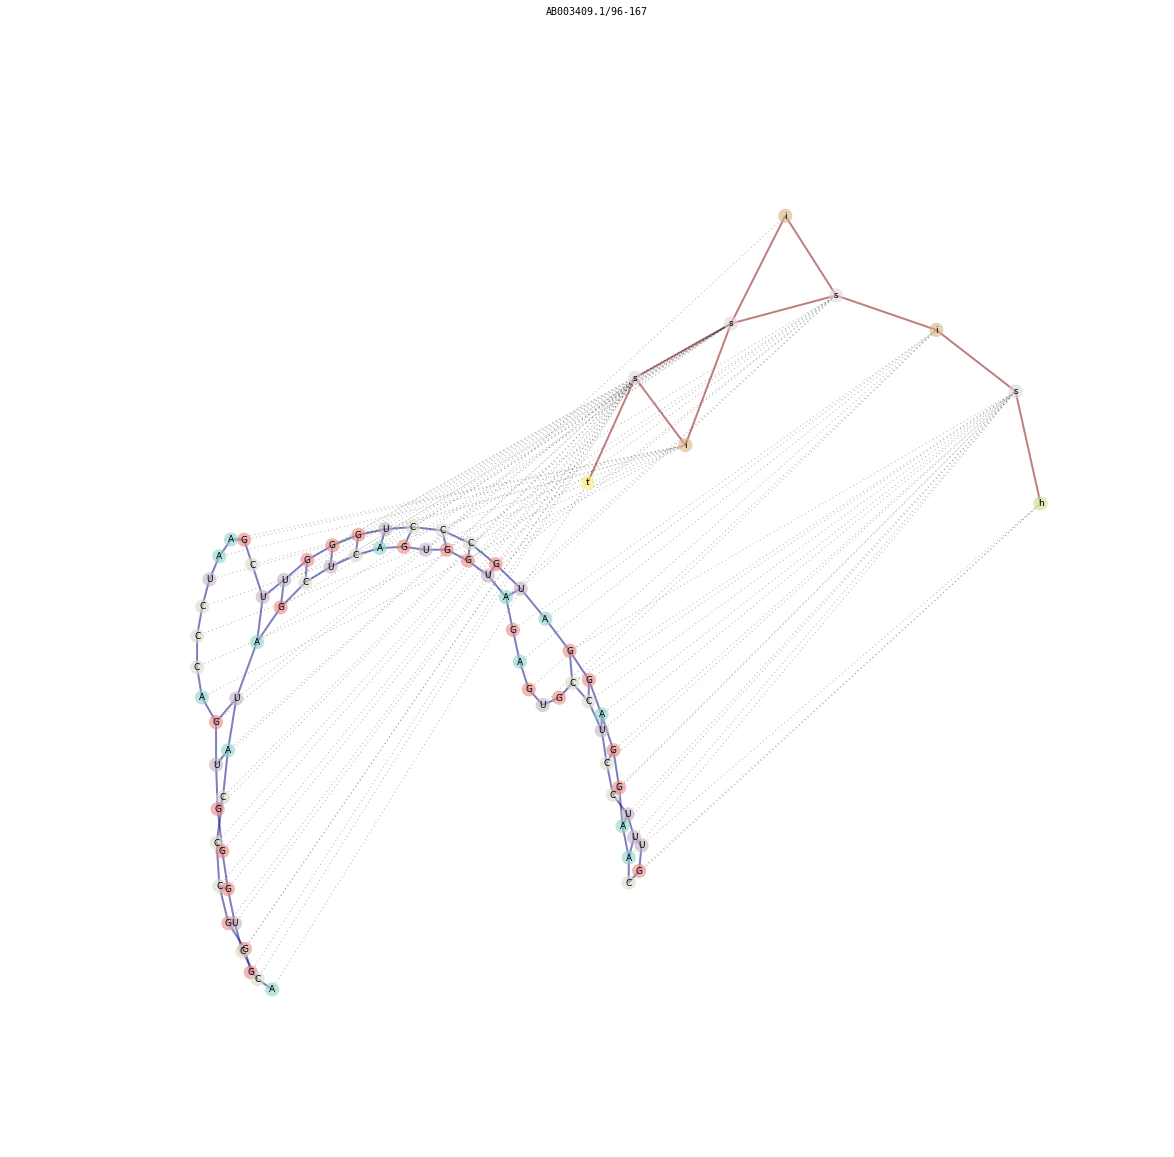

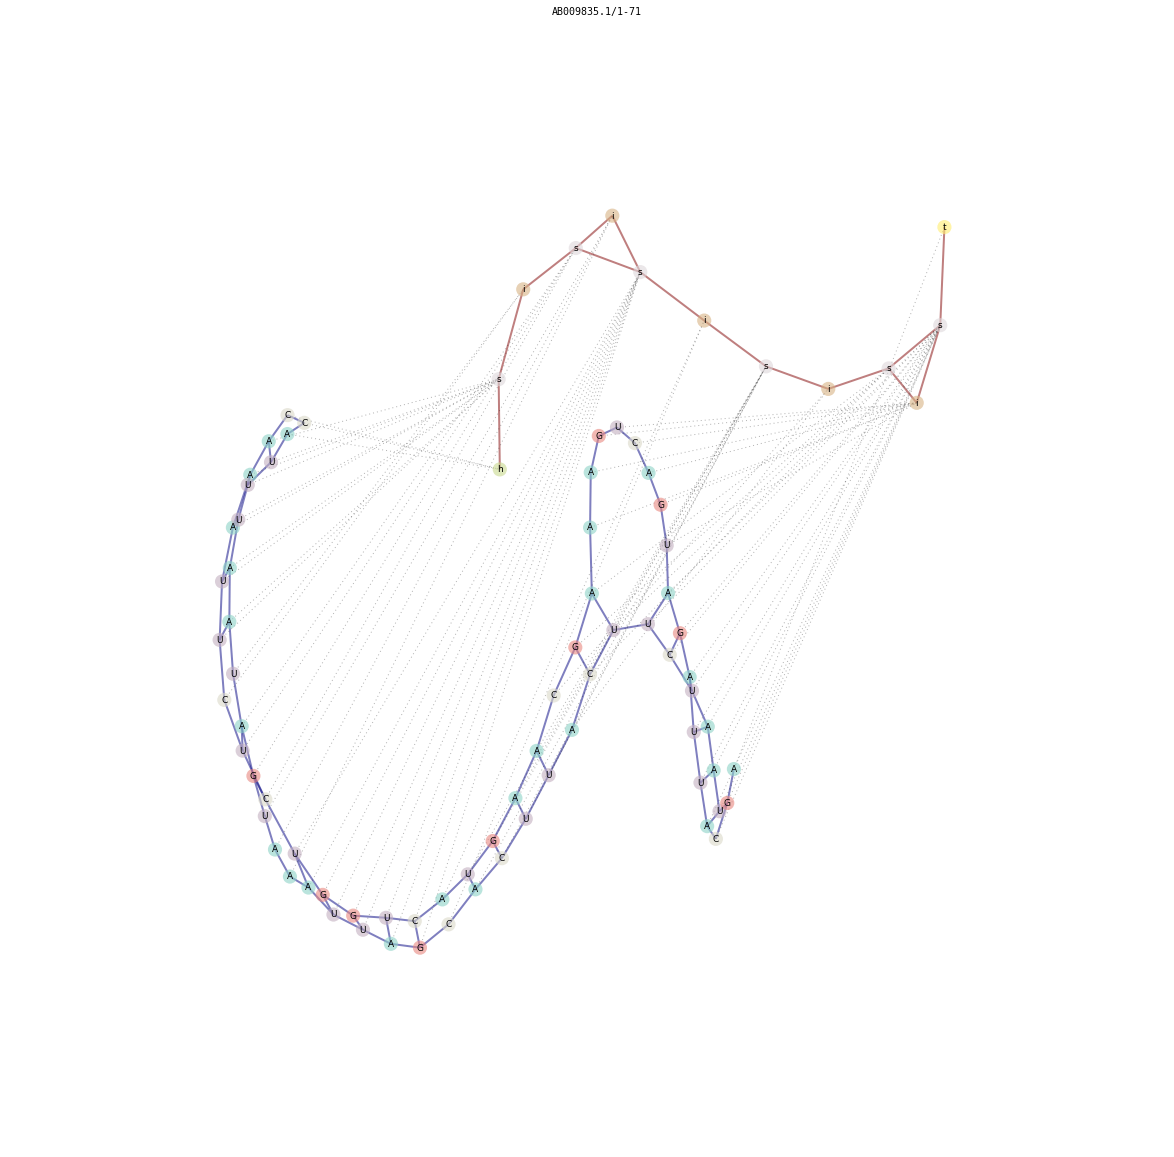

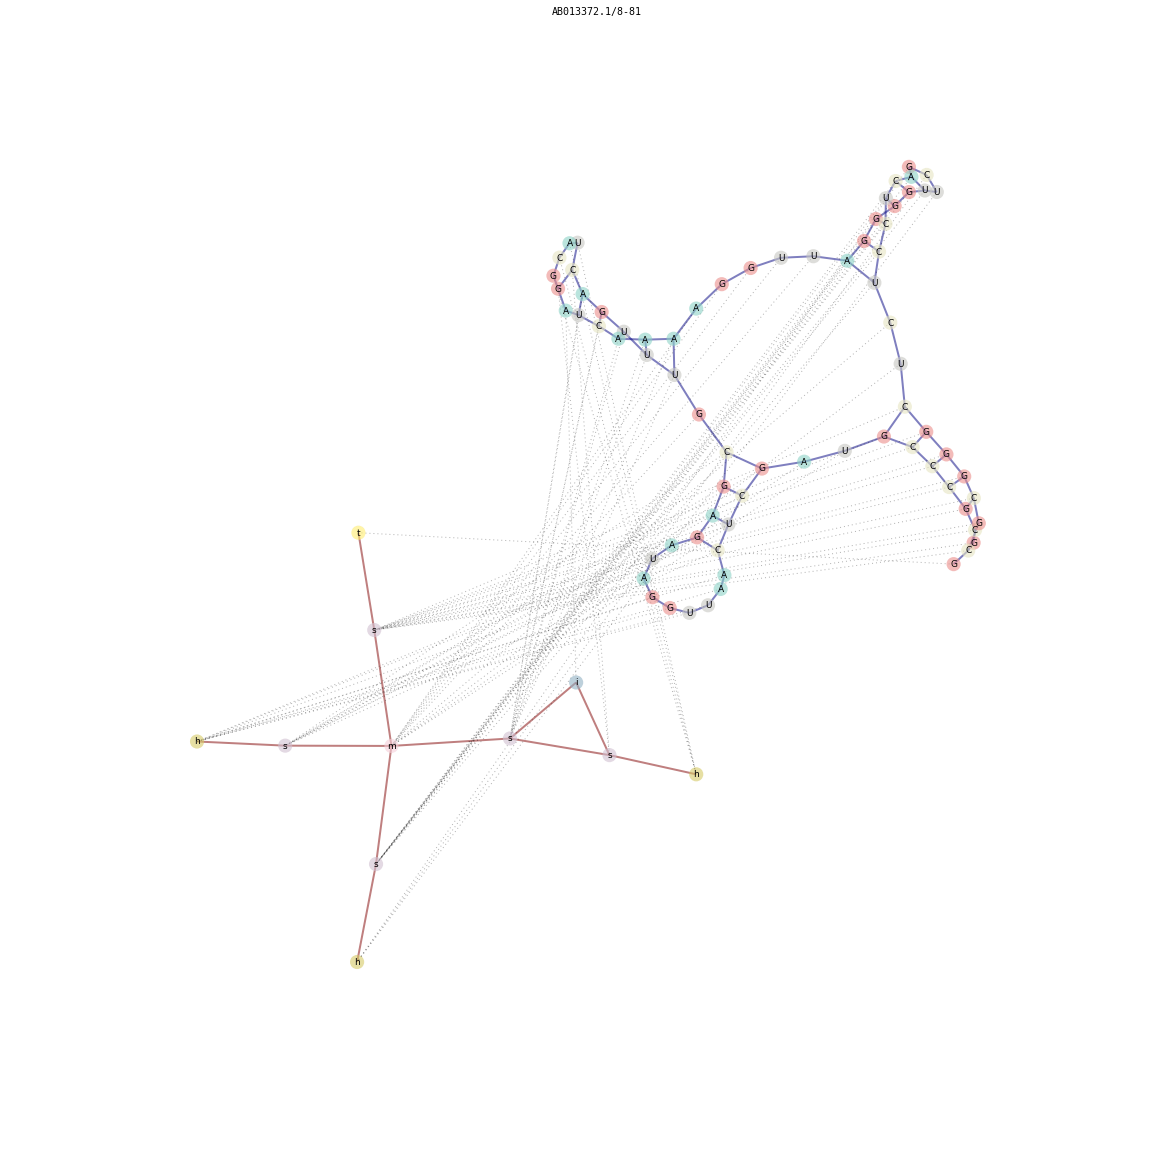

In [122]:
from GArDen.interfaces import convert, transform
from GArDen.convert.sequence import FastaToPathGraph
graphs=transform(rfam_uri(rfam_id), program=FastaToPathGraph())
from GArDen.transform.rna_structure import PathGraphToRNAFold
graphs=transform(graphs, program=PathGraphToRNAFold())
#since later partitioning needs to process all the input we limit to 10
graphs=islice(graphs,3)
graphs = annotate(graphs)
my_opt.update({'size':20, 'vertex_color':'_label_', 'colormap':'Set3','prog':'sfdp', 'edge_label':None,'ignore_for_layout':'nesting'})
plot(graphs,opts=my_opt)

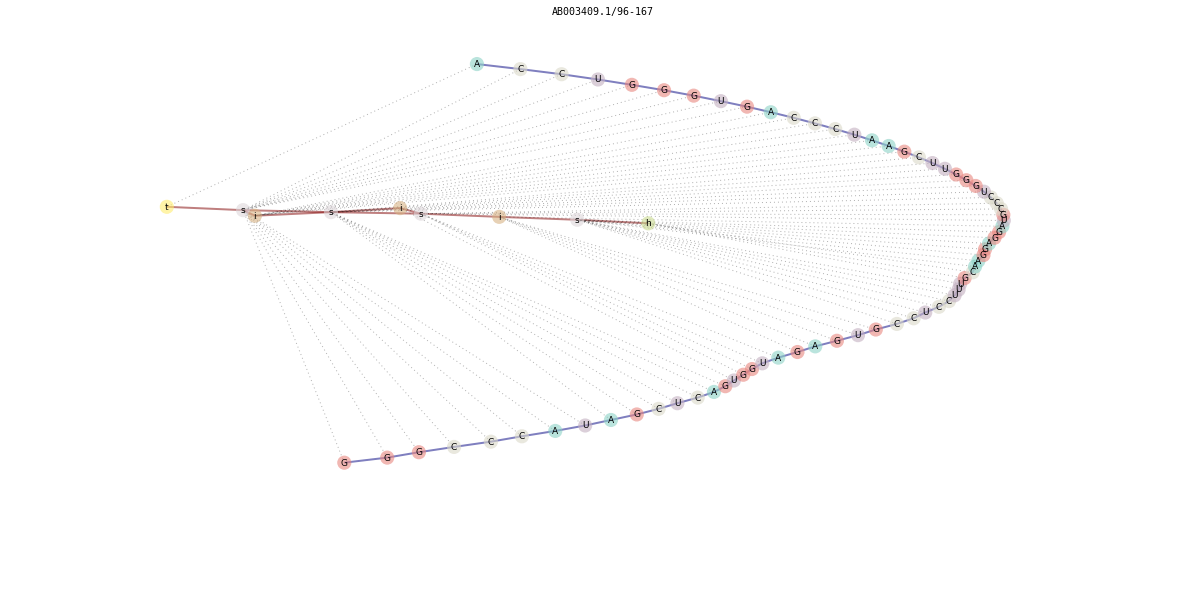

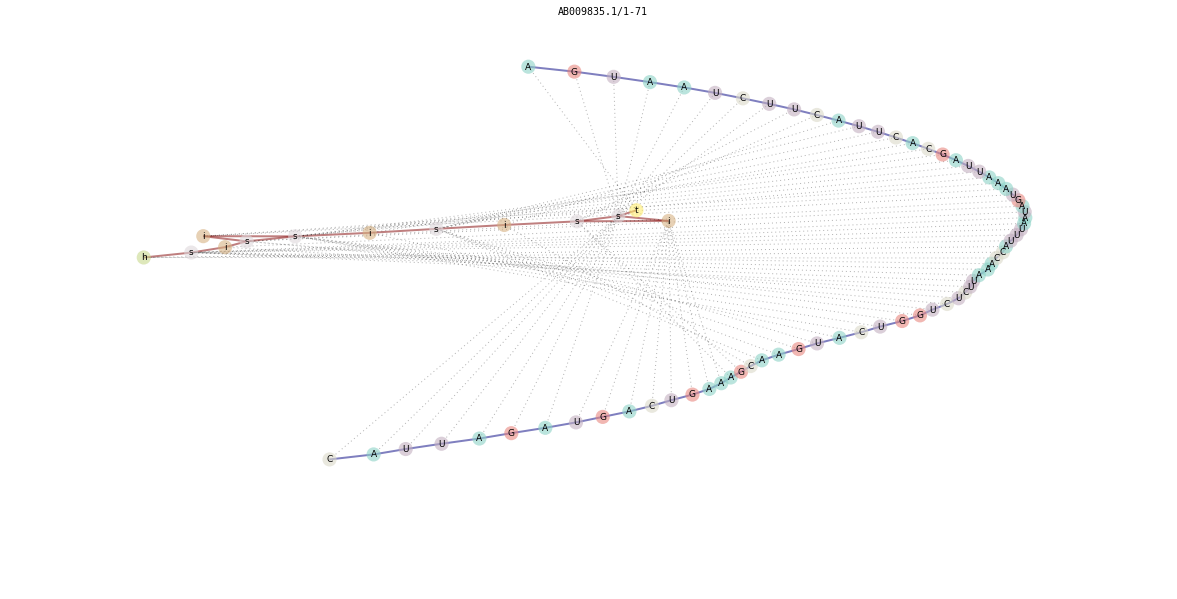

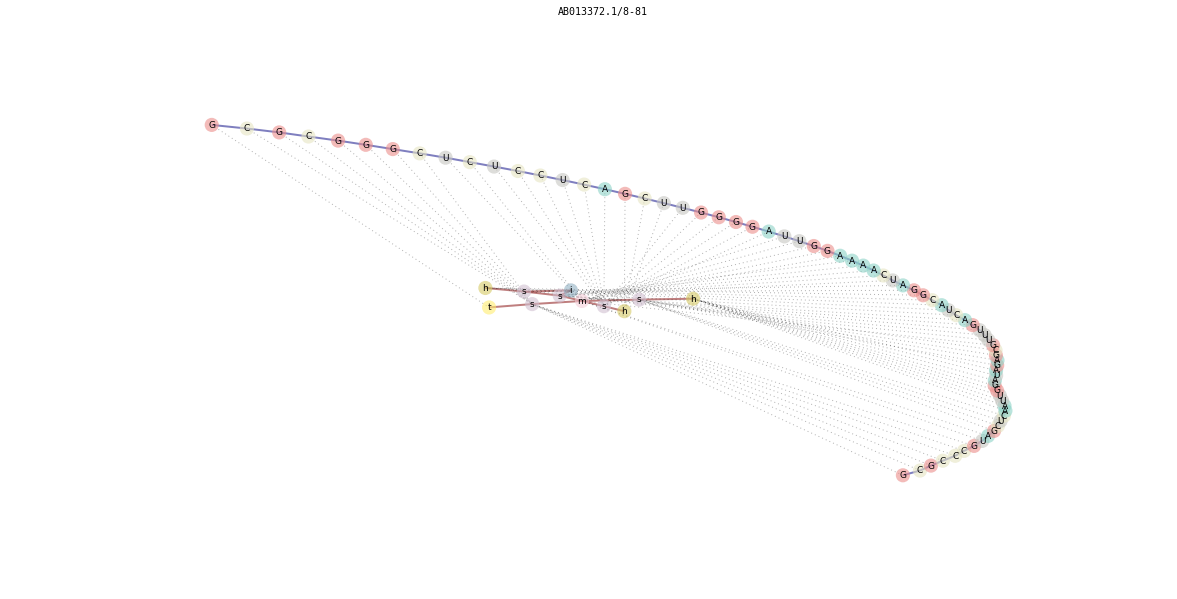

In [123]:
from GArDen.interfaces import convert, transform
from GArDen.convert.sequence import FastaToPathGraph
graphs=transform(rfam_uri(rfam_id), program=FastaToPathGraph())
from GArDen.transform.rna_structure import PathGraphToRNAFold
graphs=transform(graphs, program=PathGraphToRNAFold())
#since later partitioning needs to process all the input we limit to 10
graphs=islice(graphs,3)
graphs = annotate(graphs)
from GArDen.transform import DeleteEdge
graphs = transform(graphs,program=DeleteEdge(), parameters_priors=dict(attribute='type',value='basepair'))
my_opt.update({'size':20, 'vertex_color':'_label_', 'colormap':'Set3','prog':'neato','edge_label':None,'size_x_to_y_ratio':2})
plot(graphs,opts=my_opt)

In [104]:
def pre_process(data):
    
    from eden.converter.fasta import fasta_to_sequence
    seqs = fasta_to_sequence(data)
    
    from eden.converter.rna.rnashapes import rnashapes_to_eden
    graphs = rnashapes_to_eden(seqs, shape_type=5, energy_range=30, max_num=1)
                
    #annotate in node attribute 'type' the incident edges' labels
    from eden.modifier.graph import vertex_attributes
    graphs = vertex_attributes.incident_edge_label(graphs, level = 1, output_attribute = 'type', separator = '.')
    from eden.modifier.graph.structure import contraction, contraction_modifier
    #reduce all 'label' attributes of contracted nodes to a histogram to be written in the 'label' attribute of the resulting graph 
    label_modifier = contraction_modifier(attribute_in='type', attribute_out='label', reduction='set_categorical')
    #reduce all 'weight' attributes of contracted nodes using a sum to be written in the 'weight' attribute of the resulting graph 
    weight_modifier = contraction_modifier(attribute_in='weight', attribute_out='weight', reduction='sum')
    modifiers = [label_modifier, weight_modifier]
    #contract the graph on the 'type' attribute
    graphs = contraction(graphs, contraction_attribute = 'type', modifiers = modifiers, nesting = True)

    from eden.modifier.graph import structure 
    graphs = structure.delete_edge_type(graphs)

    from eden.modifier.graph import vertex_attributes 
    graphs = vertex_attributes.colorize(graphs, output_attribute = 'level', labels = ['X','A','U','C','G'])
    
    return graphs

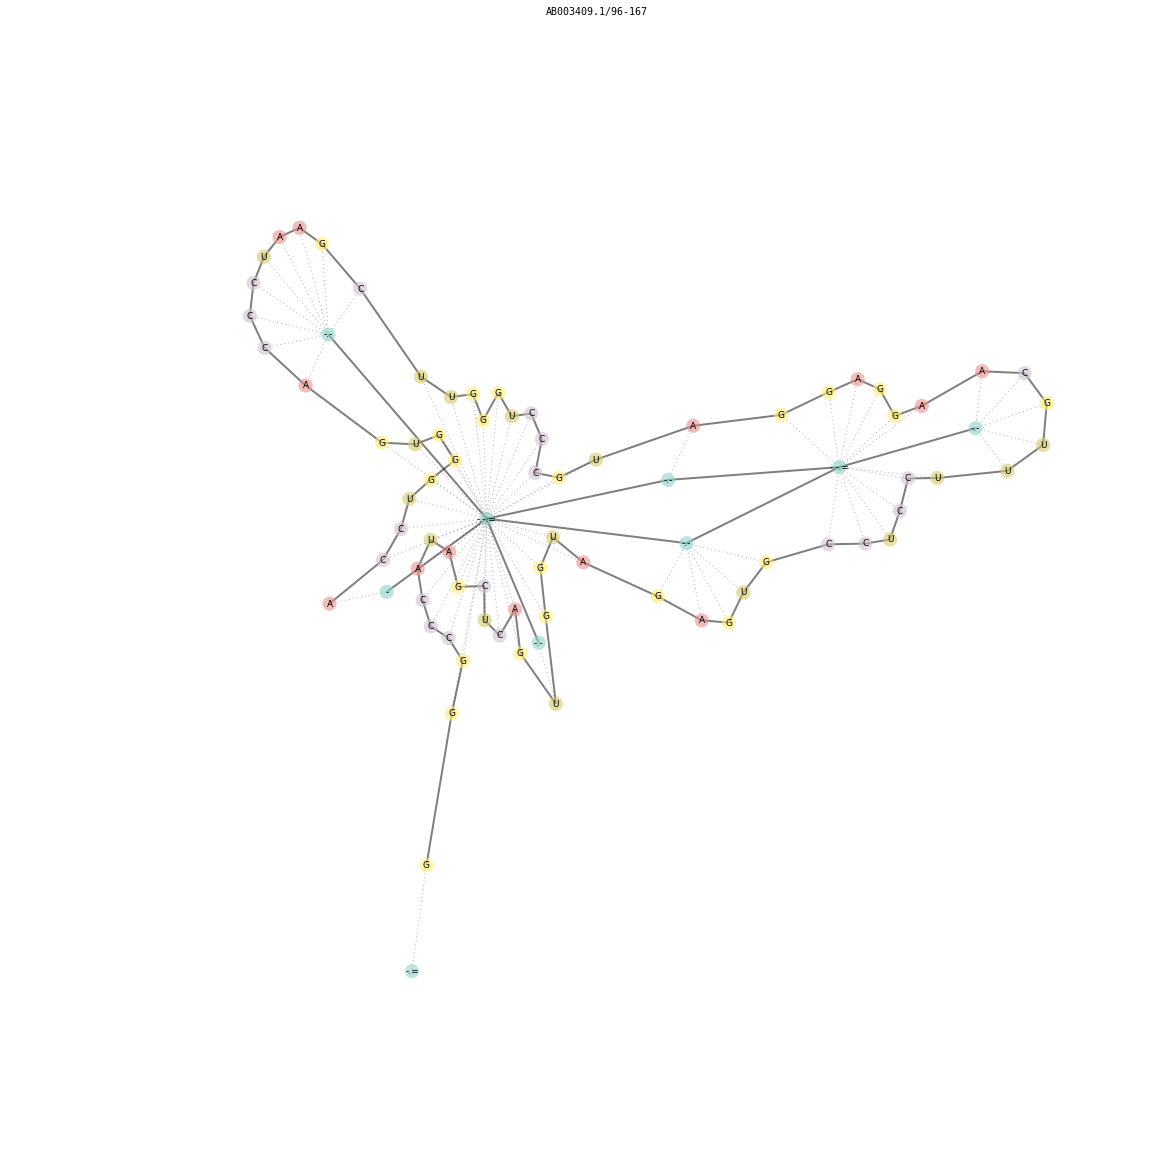

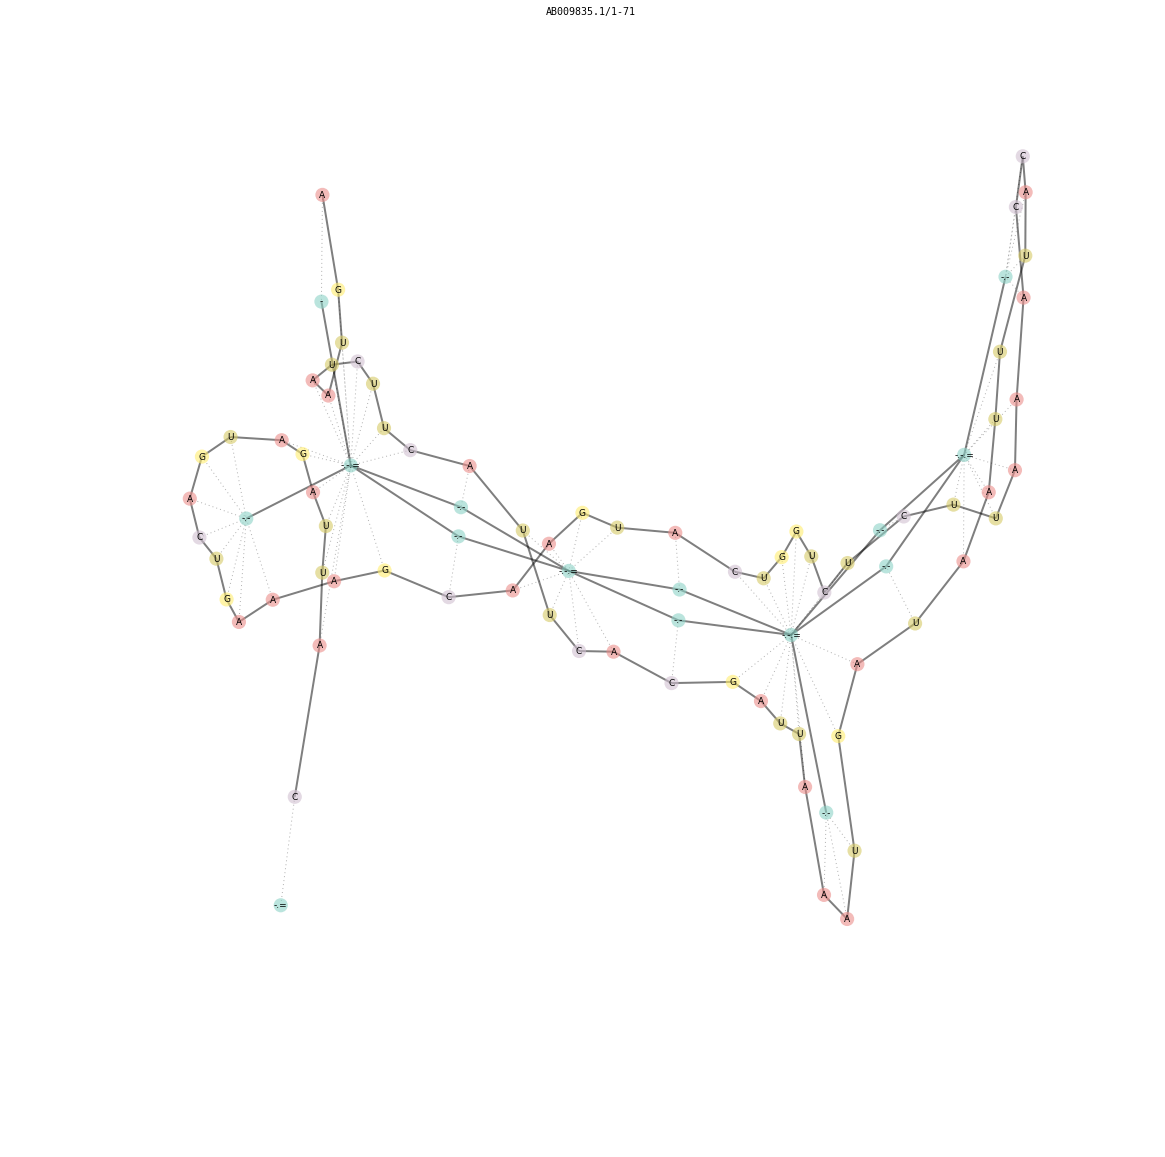

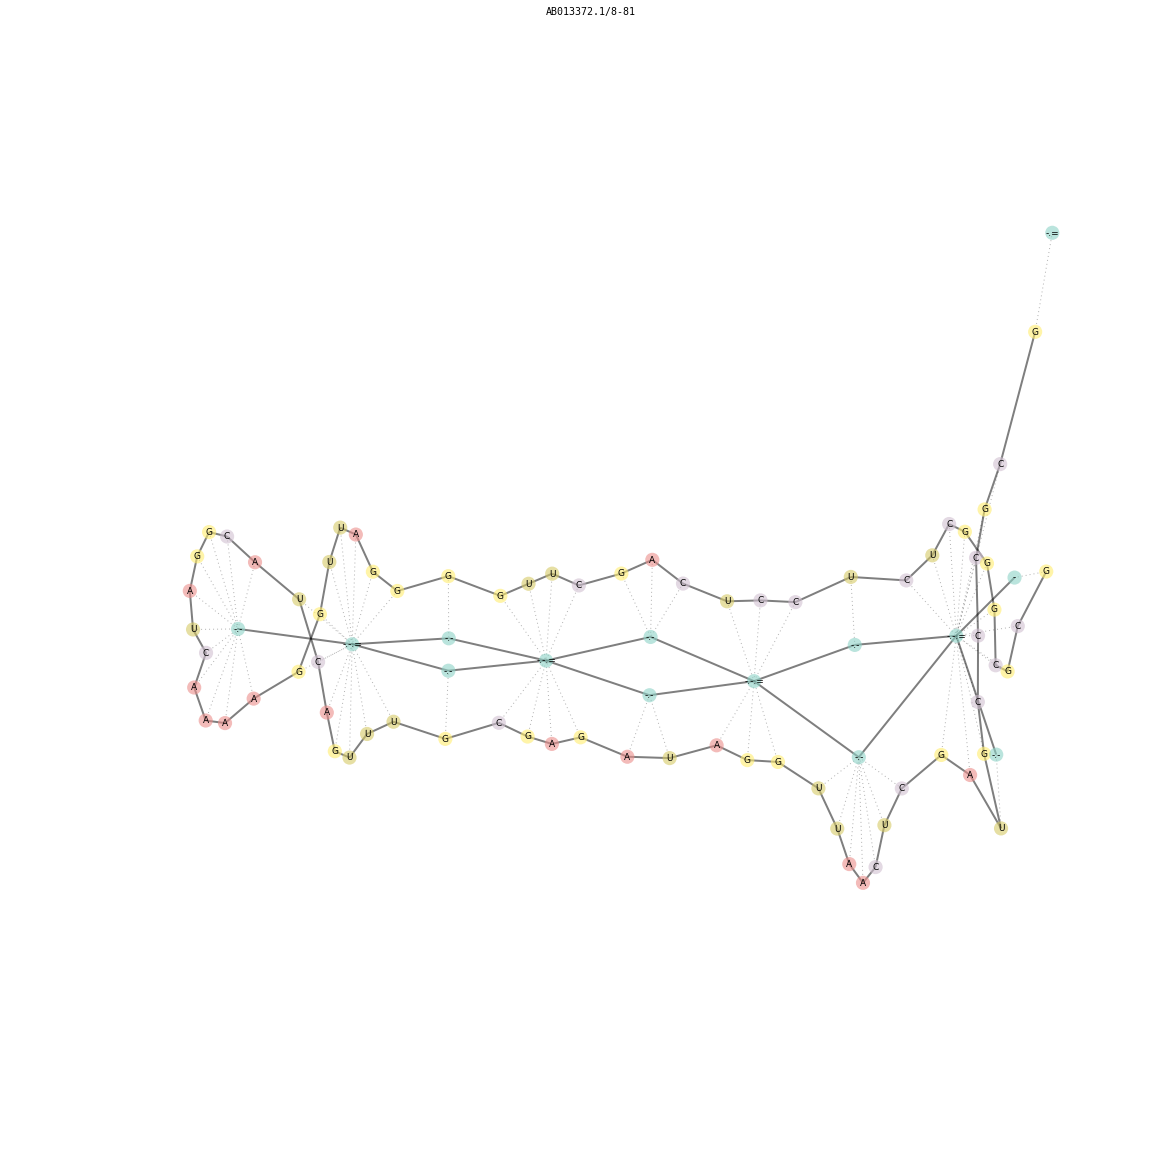

In [105]:
graphs = pre_process(rfam_uri(rfam_id))
my_opt=dict(opts)
#my_opt.update({'size':20, 'vertex_color':'level', 'colormap':'Set3','prog':'neato', 'edge_label':None})
my_opt.update({'size':20, 'vertex_color':'level', 'colormap':'Set3','prog':'sfdp', 'edge_label':None})
plot(graphs,opts=my_opt, num=3)

In [106]:
def pre_process(data):
    
    from eden.converter.fasta import fasta_to_sequence
    seqs = fasta_to_sequence(data)
    seqs = list(seqs)
    seqs = seqs[:200]
    
    # make a copy of the seqs to make negative data
    from itertools import tee
    seqs,seqs_ = tee(seqs)
    from eden.modifier.seq import seq_to_seq, shuffle_modifier
    neg_seqs = seq_to_seq(seqs_, modifier=shuffle_modifier, times=2)

    from eden.converter.rna.rnashapes import rnashapes_to_eden
    graphs = rnashapes_to_eden(seqs, shape_type=5, energy_range=30, max_num=1)
    neg_graphs = rnashapes_to_eden(neg_seqs, shape_type=5, energy_range=30, max_num=1)
    
    #learn a predictive model
    from eden.graph import Vectorizer
    vectorizer=Vectorizer(3)
    graphs,graphs_ = tee(graphs)
    from eden.util import fit
    estimator = fit(graphs_,neg_graphs, vectorizer)
    #annotate
    graphs = vectorizer.annotate(graphs, estimator=estimator)
    # use importance as a binary label in 'type'
    from eden.modifier.graph.vertex_attributes import discretize
    graphs = discretize(graph_list = graphs, output_attribute = 'type', input_attribute='importance', interval=1)

    from eden.modifier.graph.structure import contraction, contraction_modifier
    #reduce all 'label' attributes of contracted nodes to a histogram to be written in the 'label' attribute of the resulting graph 
    label_modifier = contraction_modifier(attribute_in='type', attribute_out='label', reduction='set_categorical')
    modifiers = [label_modifier]
    #contract the graph on the 'type' attribute
    graphs = contraction(graphs, contraction_attribute = 'type', modifiers = modifiers, nesting = True)

    from eden.modifier.graph import structure 
    #graphs = structure.delete_edge_type(graphs, edge_type_key='basepair')

    from eden.modifier.graph import vertex_attributes 
    graphs = vertex_attributes.colorize(graphs, output_attribute = 'level', 
                                        labels = ['A','U','C','G', '-1','0','1','2'])
    
    return graphs

Positive data: Instances: 200 ; Features: 1048577 with an avg of 2186 features per instance
Negative data: Instances: 400 ; Features: 1048577 with an avg of 2180 features per instance
Elapsed time: 31.7 secs


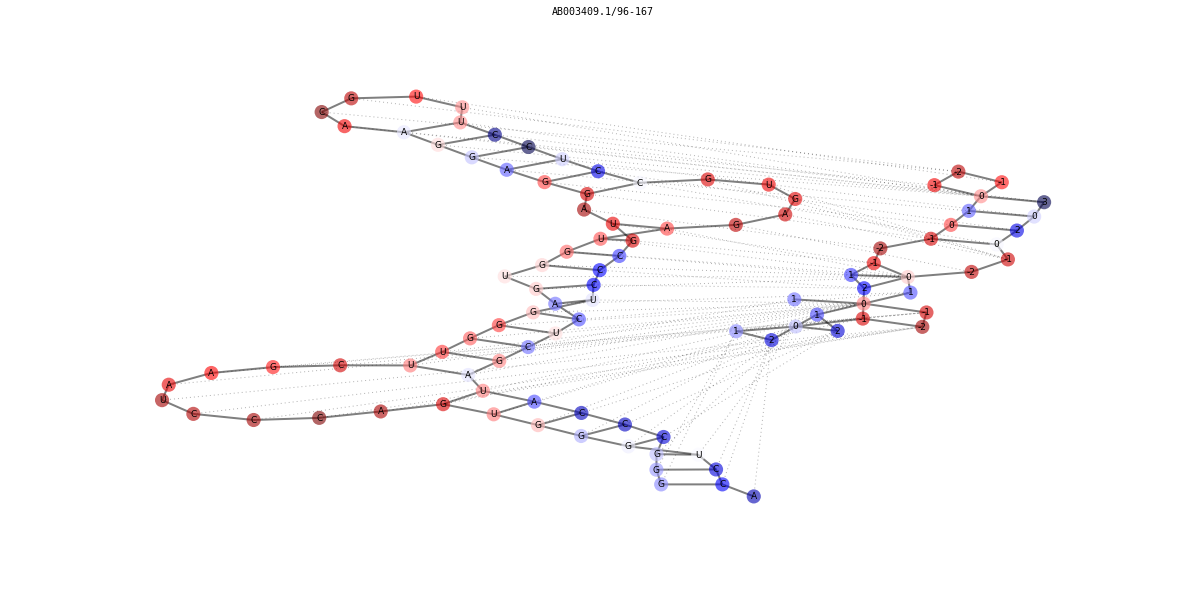

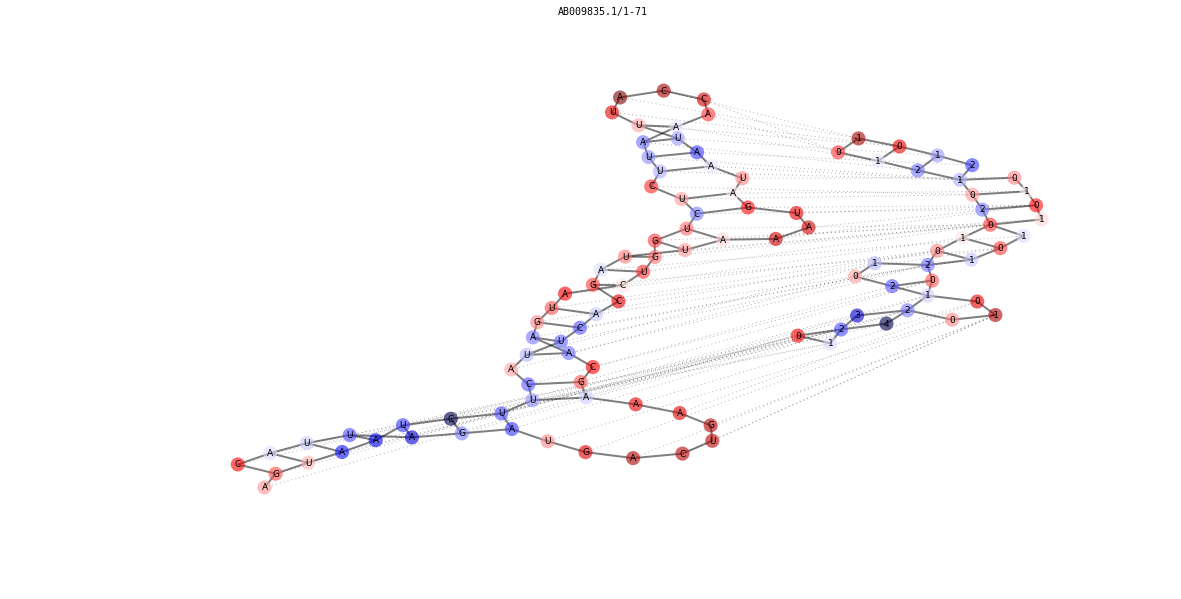

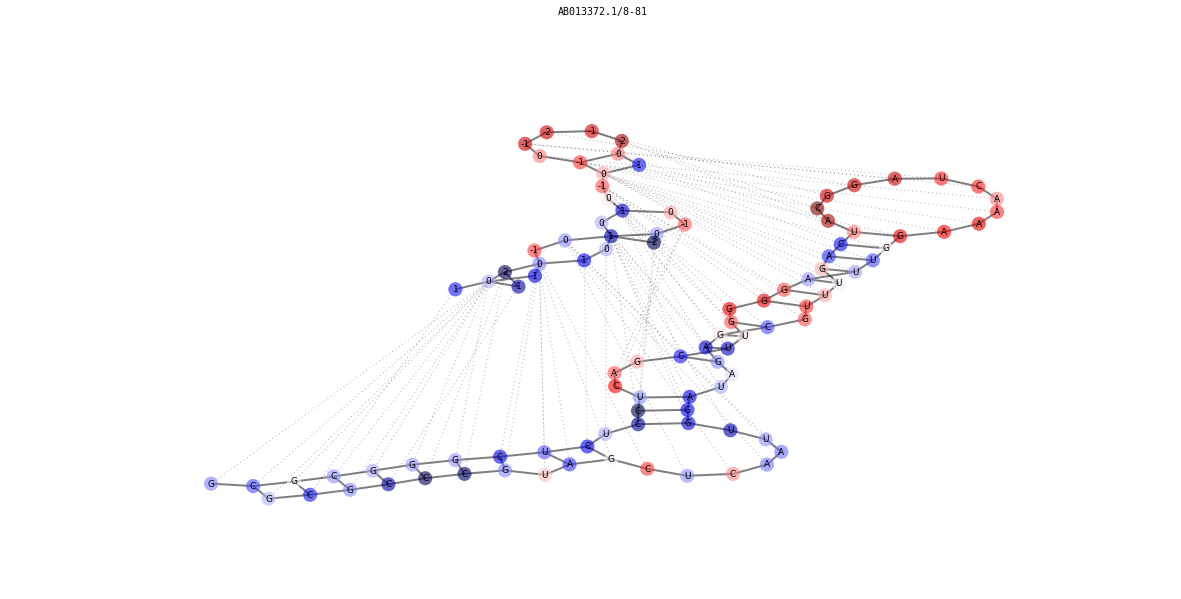

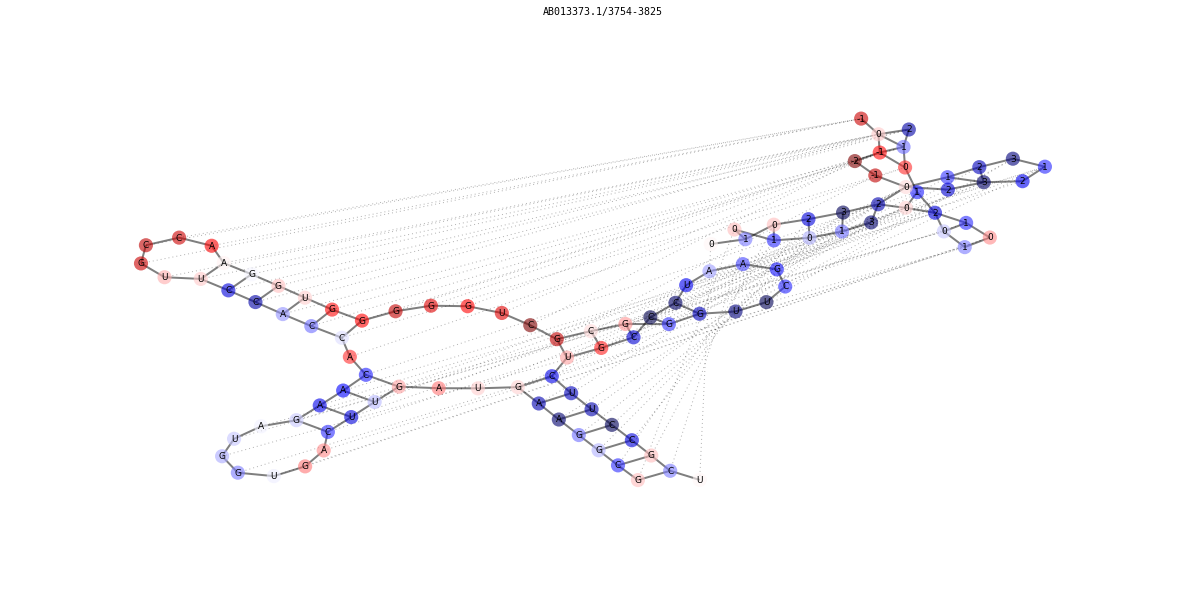

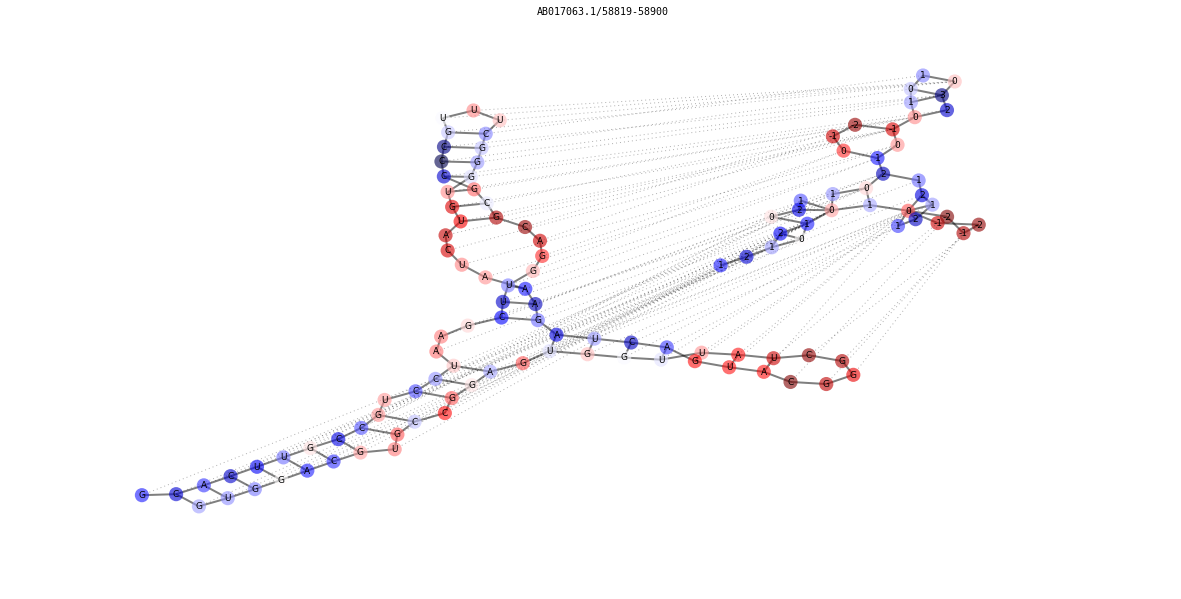

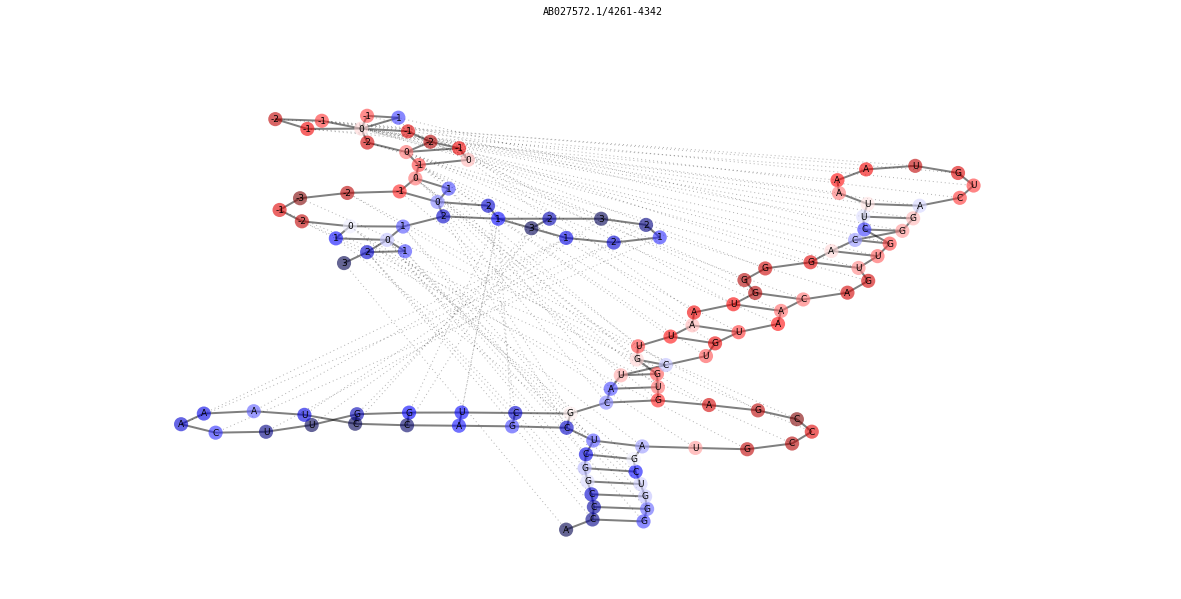

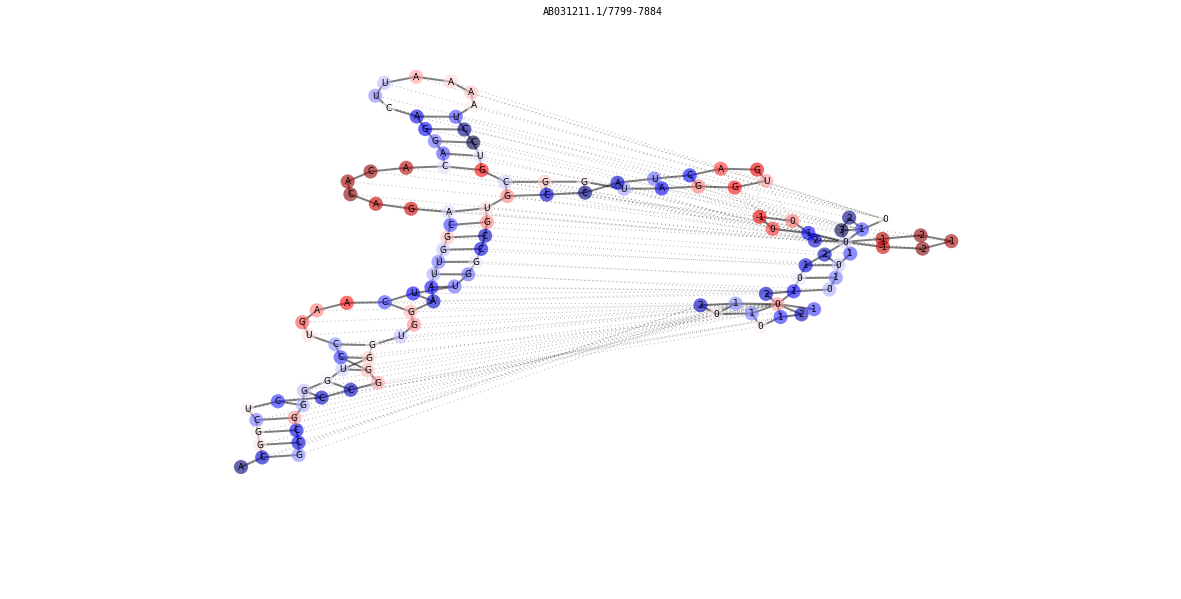

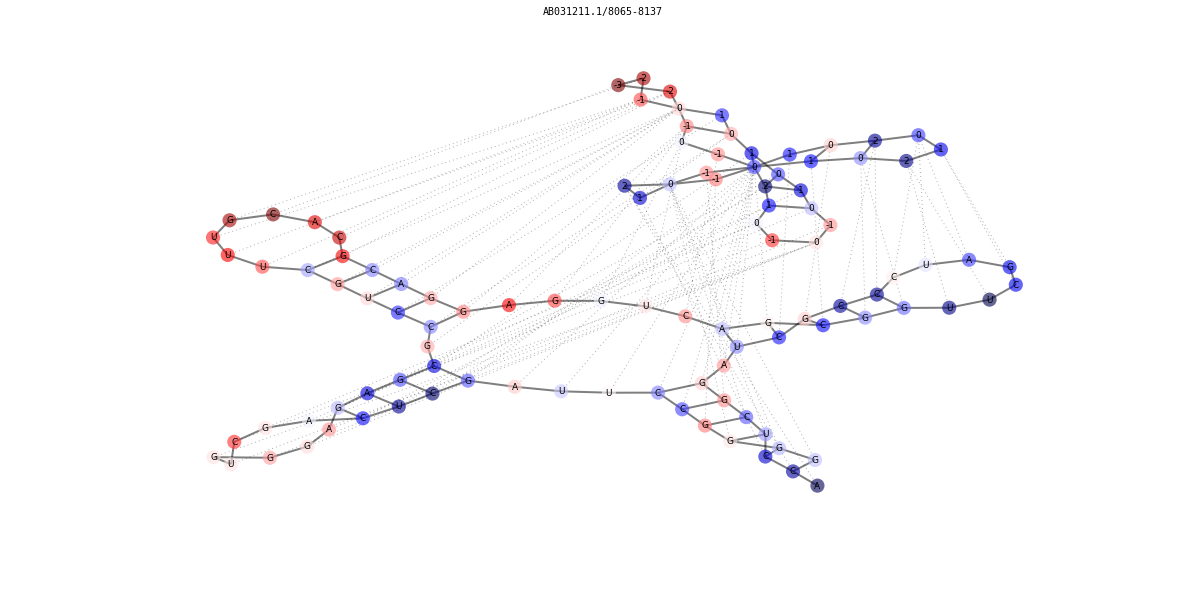

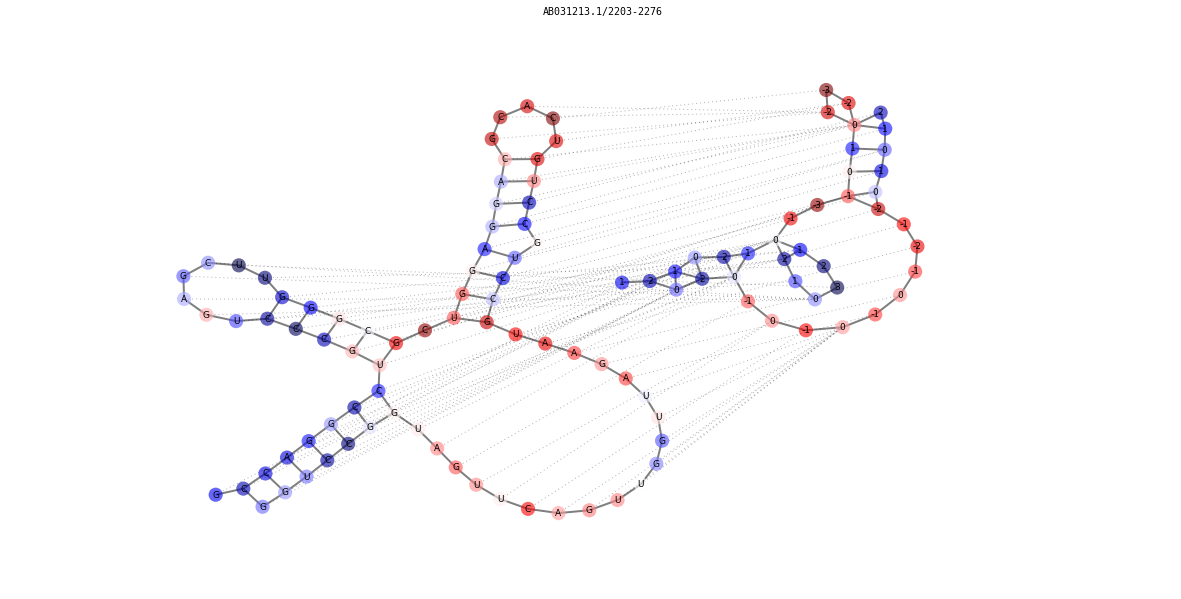

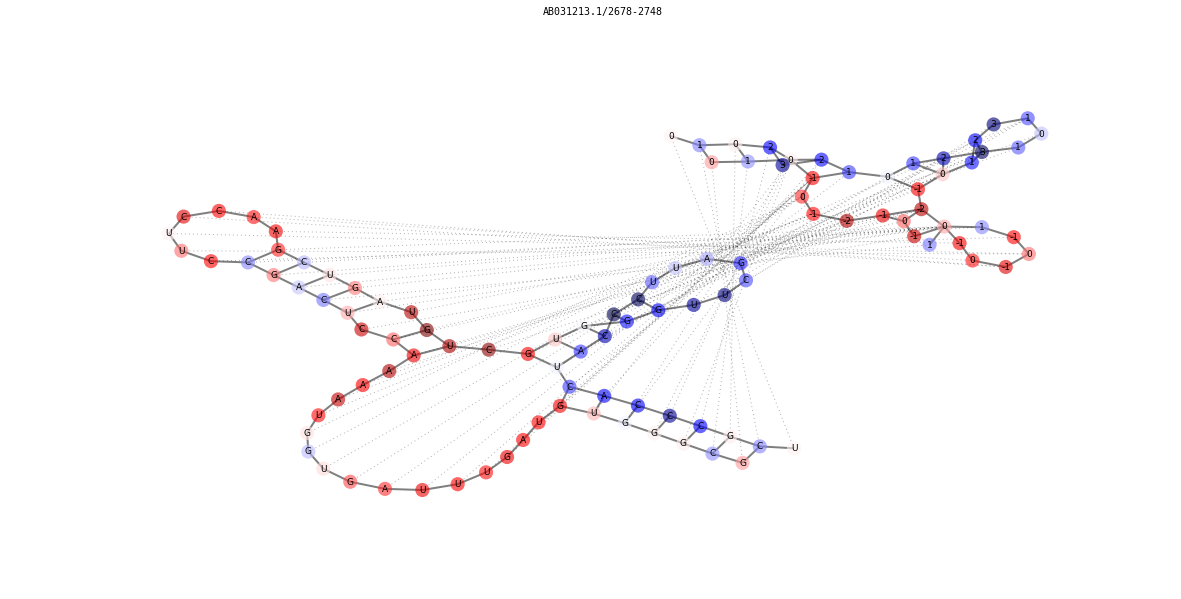

In [107]:
graphs = pre_process(rfam_uri(rfam_id))
my_opt=dict(opts)
my_opt.update({'size':20, 'vertex_color':'importance', 'colormap':'seismic', 'invert_colormap':True, 
               'prog':'neato', 'size_x_to_y_ratio':2, 'ignore_for_layout':'nesting', 'edge_label':None})
plot(graphs,opts=my_opt, num=10)

---